## THE (AN)HARMONIC OSCILLATOR
In this post, we’ll put into practice what we learned in the previous articles on harmonic and anharmonic oscillators. Our goal is to compute the eigenvalues and eigenfunctions of both systems using Python and verify the loss of equal level spacing in the anharmonic case.

Along the way, we’ll see how numerical simulations help build intuition about the physics of quantum circuits, and we’ll learn how to extract spectra and wavefunctions with just a few lines of code.

Let’s start with the harmonic oscillator. The system we are modeling is an ideal LC circuit with capacitance $C = 90$ fF and inductance $L = 10$ nH. Such a circuit behaves as a perfect harmonic oscillator with resonance frequency

$$
\omega = \frac{1}{\sqrt{LC}}.
$$

In the flux representation, the corresponding potential energy takes the familiar parabolic form

$$
V(\phi) = \frac{1}{2L}\,\phi^{2},
$$

which we will implement and plot in the code below.

Using this expression for the potential, the analytical energy levels are given by

$$
E_n = \hbar \omega \left(n + \tfrac12 \right),
$$

which provides the exact spectrum of the harmonic oscillator.





In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.constants import h, hbar, pi, e
import qutip as qt
from scipy.special import pbdv, mathieu_cem,mathieu_sem,  mathieu_a, mathieu_b
from math import factorial

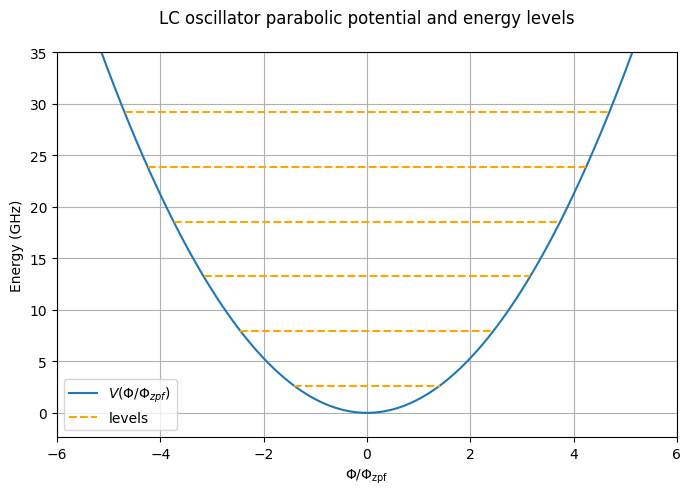

In [3]:
# Circuit parameters
L = 10e-9       # H
C = 90e-15      # F

# Derived parameters
omega = 1.0 / np.sqrt(L*C)      # rad/s
f0 = omega / (2*pi)             # Hz

Z = np.sqrt(L/C)                # Ohm (LC characteristic impedance)
phi_zpf = np.sqrt(hbar * Z / 2) # Weber


# Range in which represent the potential
N = 6
phi = np.linspace(-N*phi_zpf, N*phi_zpf, 1000)

# Parabolic potential V(phi)
V_phi_J = phi**2 / (2.0 * L) #expressed in Joules
V_phi_GHz = (V_phi_J / h) / 1e9 #expressed in GHz

# Number of levels to plot
levels = 6


# Plot
plt.figure(figsize=(8,5))
plt.plot(phi/phi_zpf, V_phi_GHz, label=r'$V(\Phi/\Phi_{zpf})$', color='C0')
for n in range(levels):
    E_n = (f0 * (n + 0.5)) #analytical energy levels in Hz
    x_lim=np.sqrt(h*E_n*2*L)
    plt.hlines(E_n/1e9, -x_lim/phi_zpf, x_lim/phi_zpf, colors='orange', linestyles='dashed', label='levels' if n==0 else None)

plt.xlabel(r'$\Phi/\Phi_{\mathrm{zpf}}$')
plt.ylabel('Energy (GHz)')


plt.title(f"LC oscillator parabolic potential and energy levels\n")
plt.xlim(-N, N)
plt.ylim(top=35)
plt.grid(True)
plt.legend()
plt.show()


We now go one step further and compute the energy levels directly from the Hamiltonian. For a harmonic LC oscillator, the Hamiltonian expressed in the number basis is
$$
H=\hbar \omega(0.5+\hat{n})
$$
so the eigenvalues can be obtained simply by diagonalizing $H$ in the Fock basis using QuTiP.

We also aim to compute and plot the eigenvectors of $H$ expressed in the flux basis $\Phi$. QuTiP returns eigenstates in the number-state (Fock) basis, so we must transform them into the $\Phi$ representation by expanding the wavefunction as
$$
\psi_n(\Phi) = \braket{ \Phi|n}  
$$
here $n$ is the harmonic‐oscillator eigenfunction.
The flux-basis harmonic-oscillator eigenfunctions are

$$
\psi_n(\Phi)
= \left( \frac{1}{2^n n!} \right)^{1/2}
  \left( \frac{1}{\pi^{1/2} \,\sqrt{2} \Phi_{\mathrm{zpf}}} \right)^{1/2}
  H_n\!\left( \frac{\Phi}{\sqrt{2}\Phi_{\mathrm{zpf}}} \right)
  \exp\!\left[ -\frac{1}{2}\left(\frac{\Phi}{\sqrt{2}\Phi_{\mathrm{zpf}}}\right)^2 \right]
$$


Directly evaluating Hermite polynomials can be numerically unstable for large $n$. A more robust approach uses the **parabolic-cylinder functions** from SciPy, which satisfy

$$
H_n(x) = 2^{n/2}\, e^{x^2/2}\, D_{-n}\!\left(\sqrt{2}\,x\right)

$$
and therefore the harmonic-oscillator eigenfunctions become
$$

\psi_n(\Phi) = \frac{1}{\sqrt{n!\sqrt{2\pi}\Phi_{\rm zpf}}} 
\, D_{-n}\Bigg(\frac{\Phi}{\Phi_{\rm zpf}}\Bigg)

$$

In [ ]:
#function to change basis from n to phi
def harmonic_eigenvectors(n,phi_zpf,x):
    l_osc=phi_zpf*np.sqrt(2)
    result = pbdv(n, x / phi_zpf) / np.sqrt( l_osc * np.sqrt(np.pi) * factorial(n) ) 
    return result[0]

def from_n_to_phi(eigenstate_n, phi_zpf, x):
    #general function to change basis from n to phi of a generic state expressed in the n basis
    levels = len(eigenstate_n)
    psi_phi = 0

    for k in range(levels):
        psi_phi += eigenstate_n[k] * harmonic_eigenvectors(k, phi_zpf, x)

    return psi_phi  

    
#Harmonic oscillator Hamiltoninan
levels=6 #number of levels
a=qt.destroy(levels) #annihilation operator
H=f0/1e9*(0.5+(a.dag()*a)) #Hamiltonian in GHz

eigenvalues, eigenstates = H.eigenstates()


C:\Users\simyz\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\matplotlib\cbook.py:1719: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
C:\Users\simyz\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\matplotlib\cbook.py:1355: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


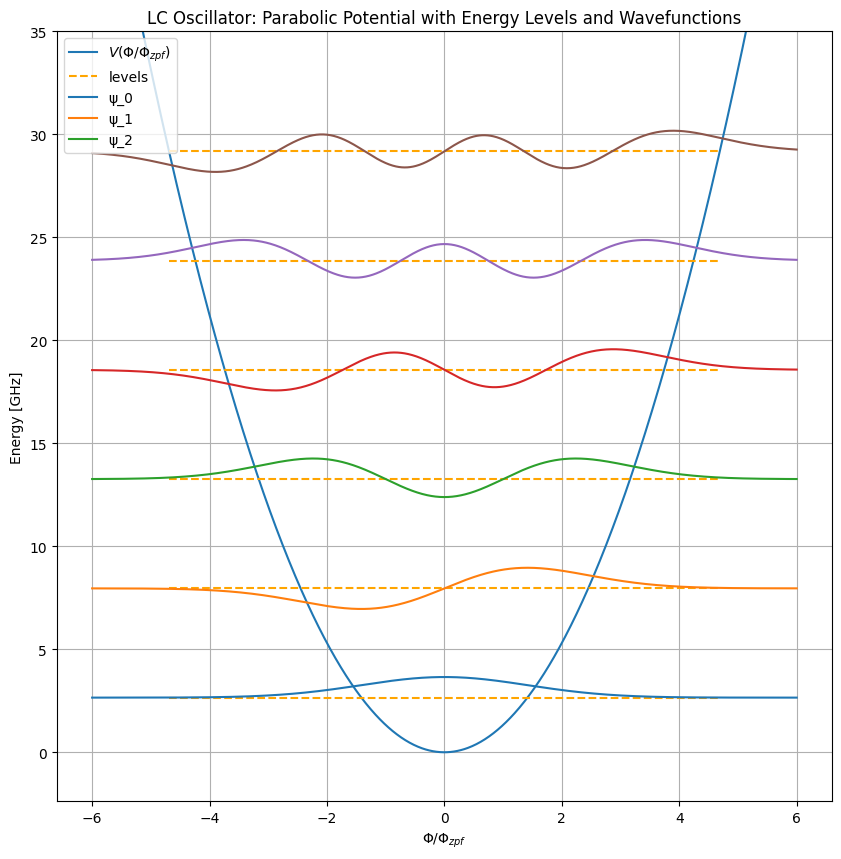

In [ ]:
# --- Plot ---
plt.figure(figsize=(10,10))
plt.plot(phi/phi_zpf, V_phi_GHz, label=r'$V(\Phi/\Phi_{zpf})$', color='C0')

# --- Energy levels and eigenfunctions ---
for n in range(levels):  
    E = eigenvalues[n]

    plt.hlines(E, -x_lim/phi_zpf, x_lim/phi_zpf, colors='orange', linestyles='dashed', label='levels' if n==0 else None)
    
    psi_phi = from_n_to_phi(eigenstates[n].full().flatten(), phi_zpf, phi)
    psi_phi /= np.array(psi_phi).max()  # scala per visualizzazione
    plt.plot(phi/phi_zpf, E + psi_phi, lw=1.5, label=f'ψ_{n}' if n<3 else "")

plt.xlabel(r'$\Phi/\Phi_{zpf}$')
plt.ylabel('Energy [GHz]')
plt.title('LC Oscillator: Parabolic Potential with Energy Levels and Wavefunctions')
plt.ylim(top=35)
plt.grid(True)
plt.legend()
plt.show()

Now, we can analyze the anharmonic oscillator formed by a capacitance in parallel with a Josephson junction. Here, the potential takes the form 

$$
V(\Phi) = E_J \cos\left(\frac{2\pi \Phi}{\Phi_0}\right),
$$

Under the assumption that the system operates in the transmon regime (which is satisfied in this case), the energy levels are approximately given by the expression

$$
E_n \approx \left( \hbar \omega - \frac{E_C}{2} \right) n - \frac{E_C}{2} n^2.
$$

As before, we will first plot the potential along with the eigenvalues calculated from this formula, and then we will compute the eigenvalues and eigenfunctions using QuTiP.


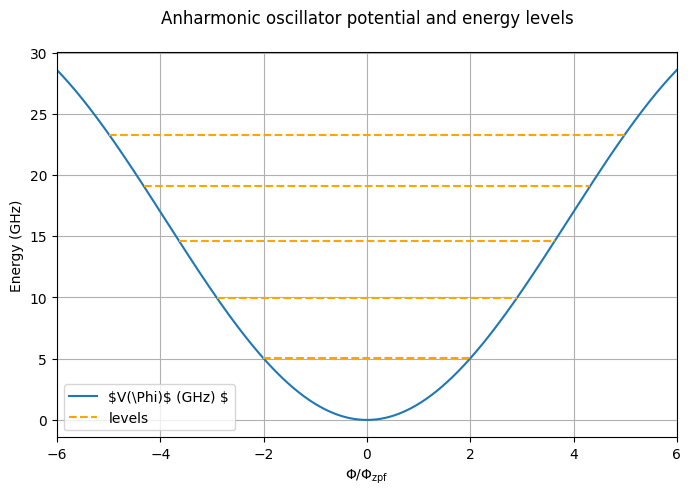

In [12]:
Phi_0=h/(2*e)  # magnetic flux quantum
Ej=(Phi_0/(2*pi))**2/L/h #Josepshon junction energy [Hz]
Ec=e**2/(2*C)/h #Charging energy [Hz]


#levels
N=6
phi = np.linspace(-N*phi_zpf, N*phi_zpf, 1000)


V_an=Ej*(1-np.cos(2*pi*phi/Phi_0))  # Josephson junction potential [Hh]
V_an_GHz=V_an/1e9 #[GHz]

levels = 6


# Plot potential
plt.figure(figsize=(8,5))
plt.plot(phi/phi_zpf, V_an_GHz, label=r'$V(\Phi)$ (GHz) $', color='C0')
#Plot energy levelsd
for n in range(levels):
    E_an = (f0 -Ec/2)*n - Ec/2*n**2  # Energy levels [Hz]
    x_lim=np.acos(1-E_an/Ej)*Phi_0/(2*pi)
    
    plt.hlines(E_an/1e9, -x_lim/phi_zpf, x_lim/phi_zpf, colors='orange', linestyles='dashed', label='levels'if n==0 else None)

plt.xlabel(r'$\Phi/\Phi_{\mathrm{zpf}}$')
plt.ylabel('Energy (GHz)')
plt.title(f"Anharmonic oscillator potential and energy levels\n")
plt.xlim(-N, N)
plt.grid(True)
plt.legend()
plt.show()

Since we are working in the transmon regime, we can perform a Taylor expansion of the cosine potential up to fourth order and rewrite the Hamiltonian in terms of the ladder operators $b$ and $b^\dagger$. By applying the rotating-wave approximation (RWA), one obtains

$$
H=\hbar\left(\omega-\frac{E_c}{\hbar}\right)b^\dagger b-\frac{E_c}{2}\, b^\dagger b^\dagger b b .
$$

Notice that the Hamiltonian written in this form commutes with the number operator $\hat{n}=b^\dagger b$. For this reason, the eigenstates of $\hat{n}$ are also eigenstates of $H$. This implies that, in the transmon regime and within the RWA, the eigenfunctions of the weakly anharmonic oscillator coincide with those of the harmonic oscillator, while the anharmonicity only affects the energy spectrum.


In [7]:
#Hamiltonian for qutip
levels=6 #number of levels
b=qt.destroy(levels) #annihilation operator
H_an=((f0-Ec)*(b.dag()*b)-Ec/2*(b.dag()*b)**2)/1e9 #Hamiltonian by expanding the cosine up to the fourth order

eigenvalues_an, eigenstates_an = H_an.eigenstates()

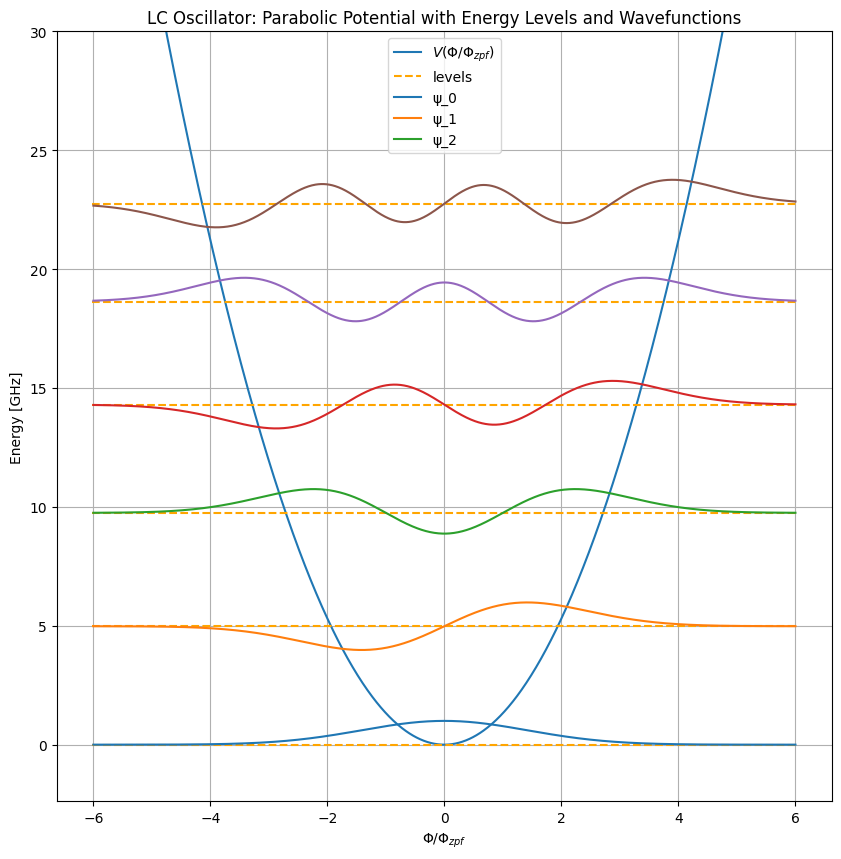

In [ ]:
# --- Plot ---
plt.figure(figsize=(10,10))
plt.plot(phi/phi_zpf, V_phi_GHz, label=r'$V(\Phi/\Phi_{zpf})$', color='C0')

# --- Energy levels and eigenfucntions ---
for n in range(levels):  
    E = eigenvalues_an[n]

    plt.hlines(E, -x_lim/phi_zpf, x_lim/phi_zpf, colors='orange', linestyles='dashed', label='levels' if n==0 else None)
    
    psi_phi = from_n_to_phi(eigenstates_an[n].full().flatten(), phi_zpf, phi) #same funcion of the harmonic oscillator
    psi_phi /= np.array(psi_phi).max()  # scale to visualize the wavefunction on top of the energy level
    plt.plot(phi/phi_zpf, E + psi_phi, lw=1.5, label=f'ψ_{n}' if n<3 else "")

plt.xlabel(r'$\Phi/\Phi_{zpf}$')
plt.ylabel('Energy [GHz]')
plt.title('Anharmonic Oscillator: Parabolic Potential with Energy Levels and Wavefunctions')
plt.ylim(top=30)
plt.grid(True)
plt.legend()
plt.show()